# Project 3 - Water Pump Clasificaiton

# Notes

**Things to add to my project - ideas from class**

Anything?


# Setup

In [1]:
from __future__ import print_function

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division
pd.set_option('display.width',5000)

In [3]:
import patsy

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Import - Training Data

This data is part of the Data Driven Competition

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/


In [4]:
# 'Values' provided for each pump location - features

df_values = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Training set values.csv')
df_values.sample(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
27311,42587,0.0,2013-01-16,Christian Outrich,1249,DWE,30.486132,-4.198886,Zahanati,0,...,unknown,soft,good,enough,enough,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
22456,50200,20000.0,2013-09-03,Oxfam,1542,DWE,36.689579,-3.336836,Kwa Samburiani,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe
14238,28212,0.0,2011-07-19,Hesawa,0,DWE,33.267847,-2.640983,Kikoba,0,...,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [5]:
# 'Labels' provided for each pump location - clasificaiton - what I am predicting

df_labels = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Training set labels.csv')
df_labels.sample(3)

,id,status_group
30659,56526,functional
34652,52134,non functional
22088,17912,non functional


# Data Import - Challenge Data

In [47]:
# 'Values' provided for each competition pump location - features

df_test_values = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Test set values.csv')
df_test_values.sample(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
14559,41653,0.0,2013-01-17,NaN,1591,NaN,35.096209,-4.663400,Kisimani,0,...,unknown,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
9900,27532,0.0,2011-03-07,Irish Ai,369,DWE,35.770028,-8.834390,Kwamario,0,...,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
1008,44827,0.0,2011-03-23,Danida,-11,DA,38.920764,-6.496556,Kwa Jambo,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe


In [48]:
# 'Labels' I will provide for each pump location - clasificaiton

df_sub = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/SubmissionFormat.csv')
df_sub.sample(3)

,id,status_group
565,71726,predicted label
10184,19429,predicted label
2139,51987,predicted label


In [49]:
df_sub = df_sub.drop('status_group', axis = 1)

# Exploratory Data Analysis

## Colum descriptions

My goal is to predict the operating condition of a waterpoint for each record in the dataset. I was provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
    * 98 unique
* date_recorded - The date the row was entered
    * 365 unique
    * year - month - day
* funder - Who funded the well
    * 1897 unique
    * look at top ones?
* installer - Organization that installed the well
    * 2145 unique
    * DWE is main one - 10x closest other, 17k
* wpt_name - Name of the waterpoint if there is one
    * 37400 unique
    * look at top ones?
* num_private - (NO PROVIDED DESC)
    * 65 unique
    * USELESS FEATURE
* population - Population around the well
    * 1049 unique
    * a lot are zero
* public_meeting - True/False
    * 2 unique
* recorded_by - Group entering this row of data
    * 1 unique
    * all the same - USELESS FEATURE
* scheme_management - Who operates the waterpoint
    * 12 unique
* scheme_name - Who operates the waterpoint
    * 2696 unique
    * USELESS FEATURE
* permit - If the waterpoint is permitted
    * 2 unique
* construction_year - Year the waterpoint was constructed
    * 55 unique
    * third are 0 - USELESS FEATURE


* Geography
    * gps_height - Altitude of the well
        * numerical
    * longitude - GPS coordinate
        * numerical
    * latitude - GPS coordinate
        * numerical
    * basin - Geographic water basin
        * 9 unique
    * subvillage - Geographic location
        * 19287 unique
    * region - Geographic location
        * 21 unique
    * region_code - Geographic location (coded)
        * 27 unique
    * district_code - Geographic location (coded)
        * 20 unique
    * lga - Geographic location
        * 125 unique
    * ward - Geographic location
        * 2092 unique


* Extraction
    * extraction_type - The kind of extraction the waterpoint uses
        * 18 unique
        * Most descriptive of extraction
    * extraction_type_group - The kind of extraction the waterpoint uses
        * 13 unique
        * Parent of extraction_type
    * extraction_type_class - The kind of extraction the waterpoint uses
        * 7 unique
        * Parent of extraction_type_group


* Overhead
    * management - How the waterpoint is managed
        * 12 unique
    * management_group - How the waterpoint is managed
        * 5 unique
    * payment - What the water costs
        * 7 unique
        * same as payment type
    * payment_type - What the water costs
        * 7 unique
        * same as payment


* Water
    * water_quality - The quality of the water 
        * 3 unique
        * Subset of quality_group
    * quality_group - The quality of the water
        * 6 unique
        * Parent group of water_quality
    * quantity - The quantity of water
        * 5 unique
        * Same as quantity_group
    * quantity_group - The quantity of water
        * 5 unique
        * Same as quantity
    * source - The source of the water
        * 10 unique
    * source_type - The source of the water
        * 7 unique
        * Subset of source
    * source_class - The source of the water
        * 3 unique
        * Subset of source_type
    * waterpoint_type - The kind of waterpoint
        * 6 unique
        * Parent of waterpoint_type_group
    * waterpoint_type_group - The kind of waterpoint
        * 7 unique
        * Subset of waterpoint_type

## Various EDA

##### Status

In [9]:
# 3 Unique status present
df_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

##### Review histograms of extraction data

* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses

18

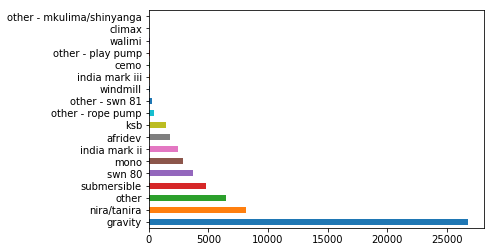

In [10]:
df_values.extraction_type.value_counts().plot('barh')
len(df_values.extraction_type.value_counts())

13

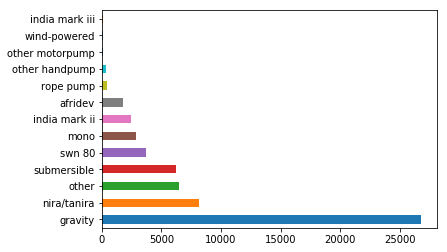

In [11]:
df_values.extraction_type_group.value_counts().plot('barh')
len(df_values.extraction_type_group.value_counts())

7

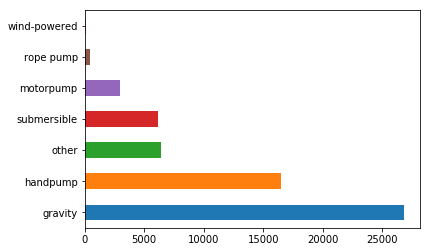

In [12]:
df_values.extraction_type_class.value_counts().plot('barh')
len(df_values.extraction_type_class.value_counts())

##### Other

In [13]:
# df_values.population.value_counts()

In [14]:
(df_values.ward.value_counts())

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
Kitunda             203
Mishamo             203
Msindo              201
Chalinze            196
Maji ya Chai        190
Usuka               187
Ngarenanyuki        172
Chanika             171
Vikindu             162
Mtwango             153
Matola              145
Zinga/Ikerege       141
Maramba             139
Wanging'ombe        139
Itete               137
Magomeni            135
Ifakara             134
Kikatiti            134
Olkokola            133
Maposeni            130
Igongolo            129
Mvomero             129
Mlangali            125
Nkoma               122
Mahongole           121
                   ... 
Rasbura               1
Burungura             1
Izia                  1
Kirongo               1
Linda                 1
Machinjioni           1
Mkumbi                1
Mitole                1
Kinungu               1
Uchindile             1
Kitete          

In [15]:
# len(df_values.management.value_counts())

In [16]:
# print(df_values.region.value_counts())
# print('Length: ',len(df_values.region.value_counts()))

In [17]:
#print(df_values.region_code.value_counts())
#print('Length: ',len(df_values.region_code.value_counts()))

In [18]:
# df_values.water_quality.value_counts()

In [19]:
#df_values.installer.value_counts()

# Test Train Split

In [20]:
# randomize data
# df_lables, df_values - combine and shuffle this data

df = pd.merge(df_labels,df_values,how = 'left')
df = df.sample(frac=1).reset_index(drop=True)

In [21]:
# Split back to X and y and then TTS
y = df[["id","status_group"]]
X = df.drop('status_group', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
X_train.shape

(47520, 40)

# Decision Tree

## Create DT on test-train-split

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [24]:
df.sample(3)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
26361,74193,functional needs repair,0.0,2013-01-18,Dwsp,0,DWE,0.000000,-2.000000e-08,Sungura,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
20612,14701,functional,0.0,2013-03-16,Government Of Tanzania,995,DWE,37.337509,-3.294457e+00,Kwa Andrea Mushi,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17985,18887,non functional,0.0,2012-10-14,Dwe,0,DWE,32.357011,-5.041233e+00,Yasine Sanga,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [34]:
# try with a few less features first 

feature_no_sel = df[['date_recorded', 'funder', 'installer', 
                   'wpt_name', 'num_private', 'subvillage', 'region', 
                   'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 
                   'scheme_management', 'scheme_name', 'construction_year', 'extraction_type', 
                   'extraction_type_group', 'management', 'management_group', 'payment', 
                   'payment_type', 'water_quality', 'quality_group', 'quantity_group', 'source', 
                   'source_type', 'waterpoint_type','region_code', 
                  'district_code']]

feature_sel = df[['id', 'status_group', 'amount_tsh','population', 'gps_height', 'longitude', 'latitude', 'basin',
                  'region', 'extraction_type_class','payment','quantity','water_quality', 'source_class',
                  'waterpoint_type_group','public_meeting','scheme_management','permit']]

In [35]:
feature_sel.sample(3)

,id,status_group,amount_tsh,population,gps_height,longitude,latitude,basin,region,extraction_type_class,payment,quantity,water_quality,source_class,waterpoint_type_group,public_meeting,scheme_management,permit
58839,33040,non functional,0.0,0,0,35.702027,-5.634046,Internal,Dodoma,motorpump,never pay,insufficient,soft,groundwater,communal standpipe,True,VWC,True
33191,73468,functional,6000.0,782,280,36.253154,-8.197777,Rufiji,Morogoro,handpump,pay annually,insufficient,milky,groundwater,hand pump,True,NaN,True
5802,7592,functional needs repair,0.0,0,0,31.772217,-1.454742,Lake Victoria,Kagera,handpump,never pay,insufficient,soft,groundwater,hand pump,True,VWC,True


In [36]:
# Change what I predict to 1,2,3

for i in range(len(feature_sel.status_group)):
    if feature_sel.status_group[i] == 'functional':
        feature_sel.at[i, 'status_group'] = 3
    elif feature_sel.status_group[i] == 'functional needs repair':
        feature_sel.at[i, 'status_group'] = 2
    else:
        feature_sel.at[i, 'status_group'] = 1

In [37]:
feature_sel=feature_sel.drop('id', axis=1)
feature_sel.sample(3)

,status_group,amount_tsh,population,gps_height,longitude,latitude,basin,region,extraction_type_class,payment,quantity,water_quality,source_class,waterpoint_type_group,public_meeting,scheme_management,permit
29409,3,50.0,0,1014,35.452738,-10.633816,Ruvuma / Southern Coast,Ruvuma,other,pay per bucket,enough,soft,surface,communal standpipe,True,VWC,True
40307,3,0.0,0,0,31.606540,-1.837134,Lake Victoria,Kagera,gravity,never pay,enough,soft,groundwater,communal standpipe,True,VWC,True
28112,3,200.0,250,963,29.650686,-4.759242,Lake Tanganyika,Kigoma,gravity,pay monthly,enough,soft,groundwater,communal standpipe,True,VWC,True


In [ ]:
# rearange columns
# cols = feature_sel.columns.tolist()
# cols = ['status_group',
#              'gps_height',
#              'longitude',
#              'latitude',
#              'population',
#              'basin',
#              'extraction_type_class',
#              'payment',
#              'quantity',
#              'water_quality',
#              'source_class',
#              'waterpoint_type_group',
#              'public_meeting',
#              'scheme_management']
# feature_sel = feature_sel[cols]
# feature_sel.sample(3)

In [38]:
#create dummy features for applicabe

feature_sel = pd.get_dummies(feature_sel,columns=list(feature_sel.columns[6:]))
feature_sel.sample(3)

,status_group,amount_tsh,population,gps_height,longitude,latitude,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,permit_False,permit_True
57889,3,0.0,1,1421,37.100276,-3.170702,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
30719,1,0.0,0,0,31.767935,-2.368016,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8754,2,0.0,150,2022,36.221785,-2.927636,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [39]:
columns = list(feature_sel.columns)
feature_sel[columns[6:]] = feature_sel[columns[6:]].astype(int)
feature_sel[columns[0]] = feature_sel[columns[0]].astype(int)

In [40]:
y = feature_sel.status_group
X = feature_sel.drop('status_group', axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
decisiontree = DecisionTreeClassifier(random_state=0)
decisiontree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [43]:
decisiontree.score(X_test,y_test)

0.74503367003367

## DT on competition datsa

In [50]:
df_test_values = df_test_values[['amount_tsh','population', 'gps_height', 'longitude', 'latitude', 'basin',
                  'region', 'extraction_type_class','payment','quantity','water_quality', 'source_class',
                  'waterpoint_type_group','public_meeting','scheme_management','permit']]

In [51]:
# rearange columns
# cols = df_test_values.columns.tolist()
# cols = ['gps_height',
#              'longitude',
#              'latitude',
#              'population',
#              'basin',
#              'extraction_type_class',
#              'payment',
#              'quantity',
#              'water_quality',
#              'source_class',
#              'waterpoint_type_group',
#              'public_meeting',
#              'scheme_management']
df_test_values

,amount_tsh,population,gps_height,longitude,latitude,basin,region,extraction_type_class,payment,quantity,water_quality,source_class,waterpoint_type_group,public_meeting,scheme_management,permit
0,0.0,321,1996,35.290799,-4.059696e+00,Internal,Manyara,other,never pay,seasonal,soft,surface,other,True,Parastatal,True
1,0.0,300,1569,36.656709,-3.309214e+00,Pangani,Arusha,gravity,never pay,insufficient,soft,groundwater,communal standpipe,True,VWC,True
2,0.0,500,1567,34.767863,-5.004344e+00,Internal,Singida,other,never pay,insufficient,soft,surface,other,True,VWC,NaN
3,0.0,250,267,38.058046,-9.418672e+00,Ruvuma / Southern Coast,Lindi,other,unknown,dry,soft,groundwater,other,NaN,VWC,True
4,500.0,60,1260,35.006123,-1.095041e+01,Ruvuma / Southern Coast,Ruvuma,gravity,pay monthly,enough,soft,groundwater,communal standpipe,NaN,Water Board,True
5,0.0,200,1685,36.685279,-3.302420e+00,Pangani,Arusha,gravity,never pay,enough,soft,groundwater,communal standpipe,True,VWC,True
6,0.0,600,550,36.398041,-7.541382e+00,Rufiji,Iringa,handpump,never pay,enough,salty,groundwater,hand pump,True,VWC,True
7,0.0,1,234,39.607420,-1.089379e+01,Ruvuma / Southern Coast,Mtwara,submersible,never pay,dry,soft,groundwater,communal standpipe,True,Water Board,True
8,30.0,40,584,39.262951,-1.082359e+01,Ruvuma / Southern Coast,Mtwara,gravity,pay per bucket,insufficient,soft,groundwater,communal standpipe,True,VWC,False
9,0.0,1,1083,37.096108,-3.251754e+00,Pangani,Kilimanjaro,gravity,pay monthly,enough,soft,groundwater,communal standpipe,True,Water Board,True


In [52]:
df_test_values = pd.get_dummies(df_test_values,columns=list(df_test_values.columns[5:]))
df_test_values.sample(3)

,amount_tsh,population,gps_height,longitude,latitude,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,...,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,permit_False,permit_True
7706,0.0,1,1647,34.869570,-4.904366,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9033,500.0,80,439,37.124424,-6.682757,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4105,0.0,1,1514,34.681520,-5.062091,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [53]:
a = [0] * len(df_test_values['gps_height'])
df_test_values['scheme_management_None'] = a
df_test_values.sample(3)

,amount_tsh,population,gps_height,longitude,latitude,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,...,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,permit_False,permit_True,scheme_management_None
9412,1000.0,1,2000,34.435147,-9.572194,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3508,0.0,0,0,34.039539,-8.860077,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
951,0.0,0,0,32.672322,-2.565313,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0


In [54]:
columns = list(df_test_values.columns)
df_test_values[columns[5:]] = df_test_values[columns[5:]].astype(int)
df_test_values[columns[0]] = df_test_values[columns[0]].astype(int)

## Apply to competition data

In [55]:
df_test_labels = decisiontree.predict(df_test_values)

In [56]:
df_test_labels.shape

(14850,)

In [57]:
df_sub['status_group'] = df_test_labels

In [58]:
df_sub['status_group'] = df_sub['status_group'].astype(str)

for i in range(len(df_sub.status_group)):
    if df_sub.status_group[i] == '3':
        df_sub.at[i, 'status_group'] = 'functional'
    elif df_sub.status_group[i] == '2':
        df_sub.at[i, 'status_group'] = 'functional needs repair'
    else:
        df_sub.at[i, 'status_group'] = 'non functional'
df_sub.sample(3)

,id,status_group
4614,62342,functional needs repair
7861,33392,non functional
6463,37402,non functional


In [59]:
df_sub.status_group.value_counts()

functional                 7691
non functional             4602
functional needs repair    2557
Name: status_group, dtype: int64

In [60]:
df_sub.to_csv('./Submissions/decisionTree_5_8_10am.csv',index=False)

## Ranking

<table>
  <tr>
    <th>Best</th>
    <th>Current Rank</th>
    <th>Competitors</th>
    <th>Time</th>
  </tr>
  <tr>
    <td>0.6449</td>
    <td>1309</td>
    <td>5059</td>
    <td>May 7, 2018, 11:50 p.m.</td>
  </tr>
</table>

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth = 4,random_state=0)
clf.fit(X_train, y_train)

In [ ]:
print(clf.feature_importances_)

In [ ]:
df_test_labels2 = clf.predict(df_test_values)

In [ ]:
df_sub['status_group'] = df_test_labels2

In [ ]:
df_sub['status_group'] = df_sub['status_group'].astype(str)

for i in range(len(df_sub.status_group)):
    if df_sub.status_group[i] == '3':
        df_sub.at[i, 'status_group'] = 'functional'
    elif df_sub.status_group[i] == '2':
        df_sub.at[i, 'status_group'] = 'functional needs repair'
    else:
        df_sub.at[i, 'status_group'] = 'non functional'
df_sub.sample(3)

In [ ]:
df_sub.status_group.value_counts()

In [ ]:
df_sub.to_csv('./Submissions/decisionTree2.csv',index=False)

## Ranking

<table>
  <tr>
    <th>Best</th>
    <th>Current Rank</th>
    <th>Competitors</th>
    <th>Time</th>
  </tr>
  <tr>
    <td>0.6988</td>
    <td>1276</td>
    <td>5059</td>
    <td>May 8, 2018, 12:13 a.m.</td>
  </tr>
</table>

# Appendix

## A

In [ ]:
columns = list(feature_sel.columns)
feature_sel[columns[5:]] = feature_sel[columns[5:]].astype(int)
feature_sel[columns[0]] = feature_sel[columns[0]].astype(int)

In [ ]:
feature_sel = feature_sel.sample(frac=1).reset_index(drop=True)
y = feature_sel.status_group
X = feature_sel.drop('status_group', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.84)

In [ ]:
X_train.head(1)

## Adjust competition data

In [ ]:
df_test_values = df_test_values[['gps_height', 'longitude', 'latitude', 'basin',
                  'extraction_type_class','payment','quantity','water_quality', 'source_class',
                  'waterpoint_type_group','population','public_meeting','scheme_management']]

In [ ]:
# rearange columns
cols = df_test_values.columns.tolist()
cols = ['gps_height',
             'longitude',
             'latitude',
             'population',
             'basin',
             'extraction_type_class',
             'payment',
             'quantity',
             'water_quality',
             'source_class',
             'waterpoint_type_group',
             'public_meeting',
             'scheme_management']
df_test_values = df_test_values[cols]

In [ ]:
a = [0] * len(df_test_values['gps_height'])

In [ ]:
df_test_values = pd.get_dummies(df_test_values,columns=list(df_test_values.columns[4:]))
df_test_values.sample(5)

In [ ]:
columns = list(feature_sel.columns)
feature_sel[columns[5:]] = feature_sel[columns[5:]].astype(int)
feature_sel[columns[0]] = feature_sel[columns[0]].astype(int)

In [ ]:
df_test_values['scheme_management_None'] = a
df_test_values.head(10)

In [ ]:
list(set(X_train.columns)-set(df_test_values.columns))

##  B

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd

from IPython.display import Image

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import svm

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
pd.Series(y_train).value_counts()

## Principle Component Analysis

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)

In [ ]:
pcafeatures_train = pca.transform(X_train)

In [ ]:
from itertools import cycle

In [ ]:
# def plot_PCA_2D(data, target, target_names):
#     colors = cycle(['r','g','b'])
#     target_ids = range(len(target_names))
#     plt.figure()
#     for i, c, label in zip(target_ids, colors, target_names):
#         plt.scatter(data[target == i, 0], data[target == i, 1],
#                    c=c, label=label)
#     plt.legend()

In [ ]:
# plot_PCA_2D(pcafeatures_train, target=y_train, target_names=digits.target_names)

## Fitting Linear and RBF SVM Models

In [ ]:
# fit linear model
model_svm = svm.SVC(kernel='rbf',probability=False,cache_size=2000)
model_svm.fit(X_train, y_train)

In [ ]:
# predict out of sample
y_pred = model_svm.predict(X_test)

In [ ]:
# check accuracy
accuracy_score(y_test,y_pred)

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred)

In [ ]:
# fit rbf model
# model_svm2 = svm.SVC(kernel='rbf', gamma = 0.001)
# model_svm2.fit(X_train, y_train)

In [ ]:
# predict out of sample
y_pred2 = model_svm2.predict(X_test)

In [ ]:
# check accuracy
accuracy_score(y_test,y_pred2)

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred2)

## C

Extra code from class to utilize

In [ ]:
df.age=df.age.fillna(df.age.mean())

In [ ]:
y,X=dmatrices('survived~ pclass +age+sibsp+parch+fare',data=df,return_type='dataframe')

In [ ]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

In [ ]:
log_clf=LogisticRegression()
train_score(log_clf,X,y)

In [ ]:
# What about ROC ? 

from sklearn.metrics import roc_curve, auc

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
tpr

####  Cost Benefit Example: 

We can also optimize our models based on specific costs associated with our classification errors; here we will use specific dollar amounts as weights.

Let's say we were developing a classification model for Aircraft Delay prediction.  For this example let's assume that a true positive would 
lead to a cost savings of 2160 dollars, a false negative would cost us 2900 dollars a false positive would cost 750 dollars.  

cb = np.array([[2160, -750.0], [-2900, 0]])  

Expected_Value = #TPs(2160) - #FNs(2900) -#FPs(750)  